# 📊 Backtesting Machine Learning Trading Strategies

## Introduction

This notebook explores **backtesting Machine Learning-based trading strategies**, focusing on computationally efficient yet effective approaches, such as **Random Forest**. The goal is to evaluate the performance of these strategies using historical market data.

As with other experiments in this repository, we will leverage **Mini_lib** to facilitate key steps in applying ML to financial data. Specifically, we will:  

1. **Label the data** – Define the target variable for our ML model.  
2. **Generate and analyze features** – Extract meaningful financial indicators.  
3. **Train a model** – Use ML techniques, such as Random Forest, to derive trading signals.  
4. **Implement a strategy** – Convert model predictions into actionable trading rules.  
5. **Backtest the strategy** – Assess its performance using a robust backtesting framework.  

By following this structured approach, we aim to determine the viability of ML-driven trading strategies in real market conditions.

In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## **I. Getting Data and Making Samples**  

The first step in our workflow is to **acquire and preprocess market data**. This involves:  

1. **Fetching historical price data** – Using reliable sources to obtain asset prices.  
2. **Cleaning and preprocessing** – Handling missing values, adjusting for corporate actions, and ensuring consistency.  
   *(Note: The dataset used here is already processed, so we will skip this step.)*  
3. **Creating research samples** – Splitting the data into **Training**, **Testing**, and **Embargo** sets to prevent overfitting.  

### ⚠️ **Important Note**  
A **testing set** should be used **sparingly**! It is recommended to track the number of times it is accessed to prevent data leakage and ensure unbiased model evaluation.  


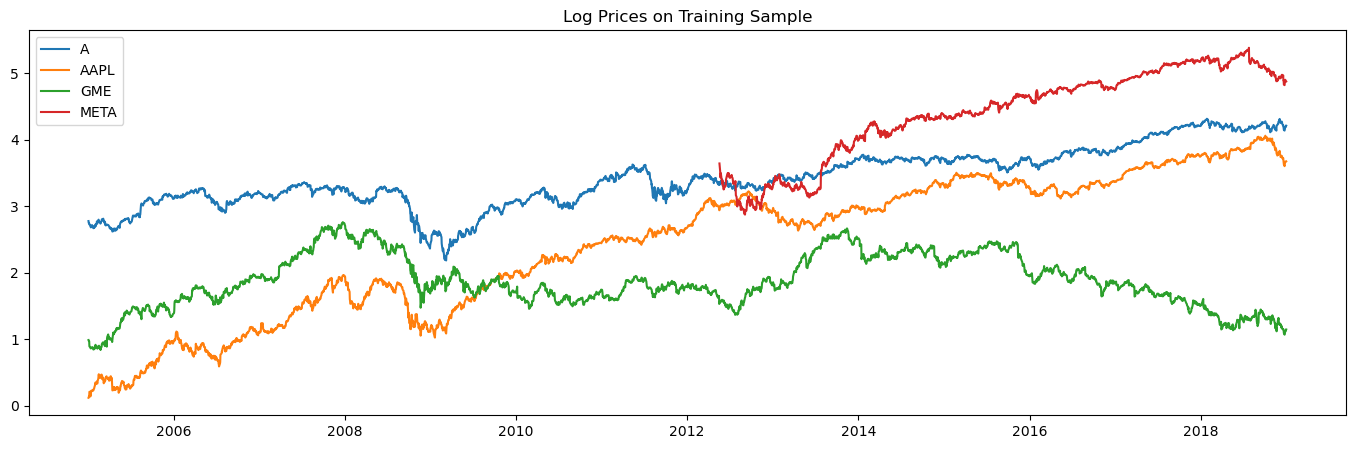

In [2]:
# I. Load data
data = dt.load_dataList(ticker_list=['A', 'AAPL', 'GME', 'META'])

# II. Making Samples
training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker]
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

# III. Let's see the training data we have on a log scale
plt.figure(figsize=(17, 5))
for asset_df in training_data.values():
    plt.plot(np.log(asset_df['close']), label=asset_df['code'].iloc[0])
plt.legend()
plt.title('Log Prices on Training Sample')
plt.show()

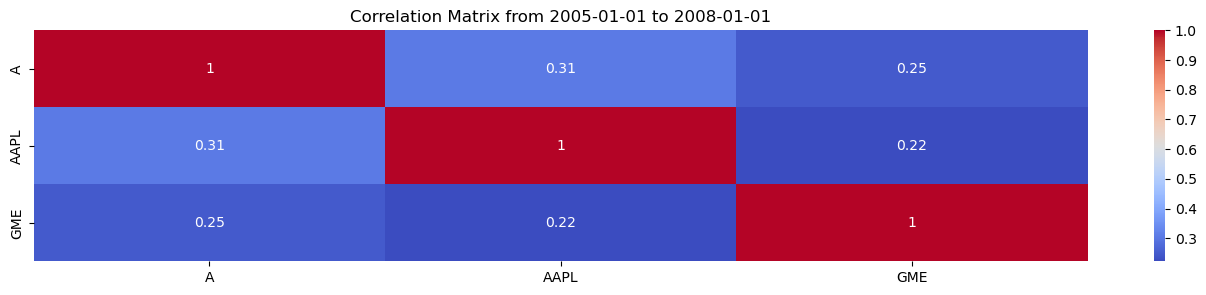

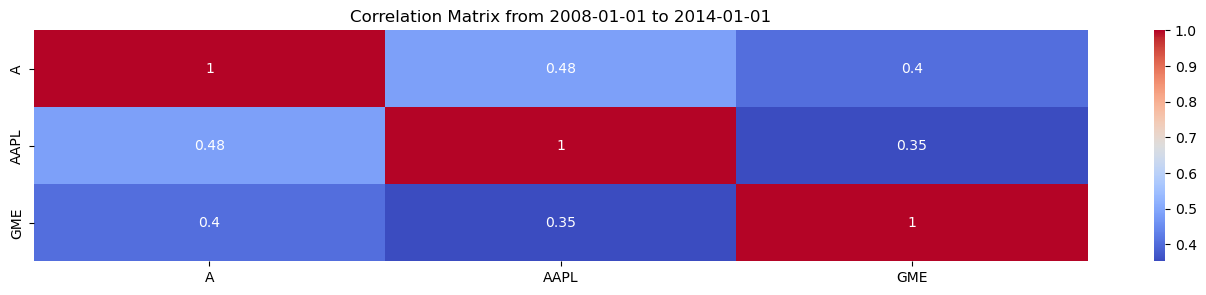

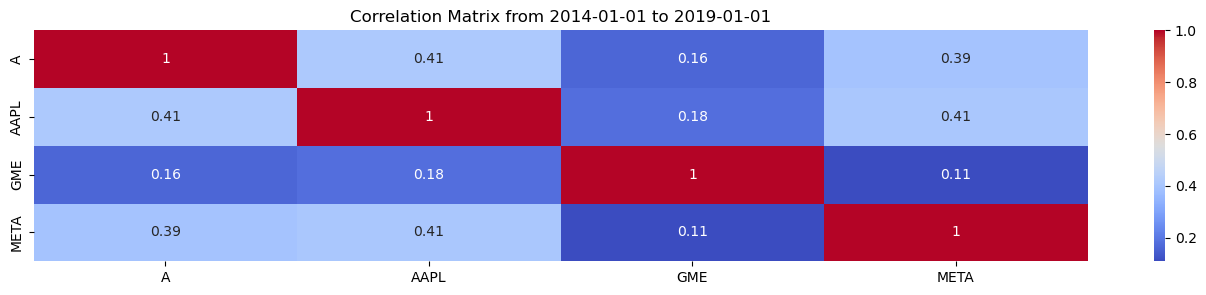

In [3]:
close_df = pd.DataFrame({ticker: asset_df['close'] for ticker, asset_df in training_data.items()})
returns_df = np.log(close_df).diff()
returns_df = returns_df.dropna()

dates_checkpoint = ['2005-01-01', '2008-01-01', '2014-01-01', '2019-01-01']
for idx in range(1, len(dates_checkpoint)):
    date = dates_checkpoint[idx]
    previous_date = dates_checkpoint[idx - 1]

    close_df = pd.DataFrame({ticker: asset_df['close'].loc[previous_date:date] for ticker, asset_df in training_data.items()})
    close_df = close_df.dropna(axis=1)
    returns_df = np.log(close_df).diff()
    returns_df = returns_df.dropna()

    correlation_matrix = returns_df.corr()
    plt.figure(figsize=(17, 3))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix from {previous_date} to {date}')
    plt.show()

### **🔍 Training Set Overview**

Our training dataset consists of **four assets**: `GME`, `META`, `AAPL`, and `A`, spanning from **2005 to 2019**. These assets exhibit distinct price behaviors over time:  

- **AAPL & META** – Consistent strong upward movement.  
- **GME** – Varied performance with shifting market conditions.  
- **A** –  Long term upward movement after a flat period.

One key observation is that **the correlation between these assets changes over time**. This is beneficial for our ML experiment as it provides:  

✅ **Diverse market regimes** – Ensuring the model learns from different conditions.  
✅ **Generalization ability** – Training across different asset behaviors without conflicting signals.  
✅ **Robustness** – Avoiding overfitting to a single asset's characteristics.  

---
## **II. Labelling Data**  

To train our classification models, we need to **define a labeling method** that captures meaningful patterns in price movements.  

### 🎯 **Objective**  
The goal is to assign labels to our dataset that reflect future market conditions, allowing our ML models to learn predictive patterns.  

### 🏷️ **Labeling Approach**  
We apply a **labeling method** to categorize market states based on price behavior. This step is crucial because:  

✅ It transforms raw price data into a structured learning problem.  
✅ It helps the model differentiate between profitable and unprofitable conditions.  
✅ It avoids bias by ensuring well-balanced class distributions.  

In [4]:
# II. Apply the labellers : for each labeller class, you can change the parameters in the dictionary and the labels will be computed for each parameter set.
#    The labels are stored in the dataframe with the name of the labeller class and the parameter set as a suffix.
tripleBarrier_params = {
    "upper_barrier": [1],
    "lower_barrier": [2],
    "vertical_barrier": [20],
    "window": [20],
    "smoothing_method": [None],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
lookForward_params = {
    "window_lookForward": [10],
    "min_trend_size": [5],
    "volatility_threshold": [1],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}

for ticker, asset_df in training_data.items():
    df = asset_df.copy()
    close_series = df['close']

    # Initialize the labellers with the parameters
    tripleBarrier_labeller = lib.tripleBarrier_labeller(data=close_series, params=tripleBarrier_params, n_jobs=1)
    lookForward_labeller = lib.lookForward_labeller(data=close_series, params=lookForward_params, n_jobs=1)
    
    # Extract the labels, here we only use the first set of parameters for each labeller
    labels_df_tb = tripleBarrier_labeller.extract()
    labels_df_lf = lookForward_labeller.extract()

    df.loc[:, 'labels_tb'] = labels_df_tb['set_0']
    df.loc[:, 'labels_lf'] = labels_df_lf['set_0']

    training_data[ticker] = df

for ticker, asset_df in testing_data.items():
    df = asset_df.copy()
    close_series = df['close']

    # Initialize the labellers with the parameters
    tripleBarrier_labeller = lib.tripleBarrier_labeller(data=close_series, params=tripleBarrier_params, n_jobs=1)
    lookForward_labeller = lib.lookForward_labeller(data=close_series, params=lookForward_params, n_jobs=1)
    
    # Extract the labels, here we only use the first set of parameters for each labeller
    labels_df_tb = tripleBarrier_labeller.extract()
    labels_df_lf = lookForward_labeller.extract()

    df.loc[:, 'labels_tb'] = labels_df_tb['set_0']
    df.loc[:, 'labels_lf'] = labels_df_lf['set_0']

    testing_data[ticker] = df

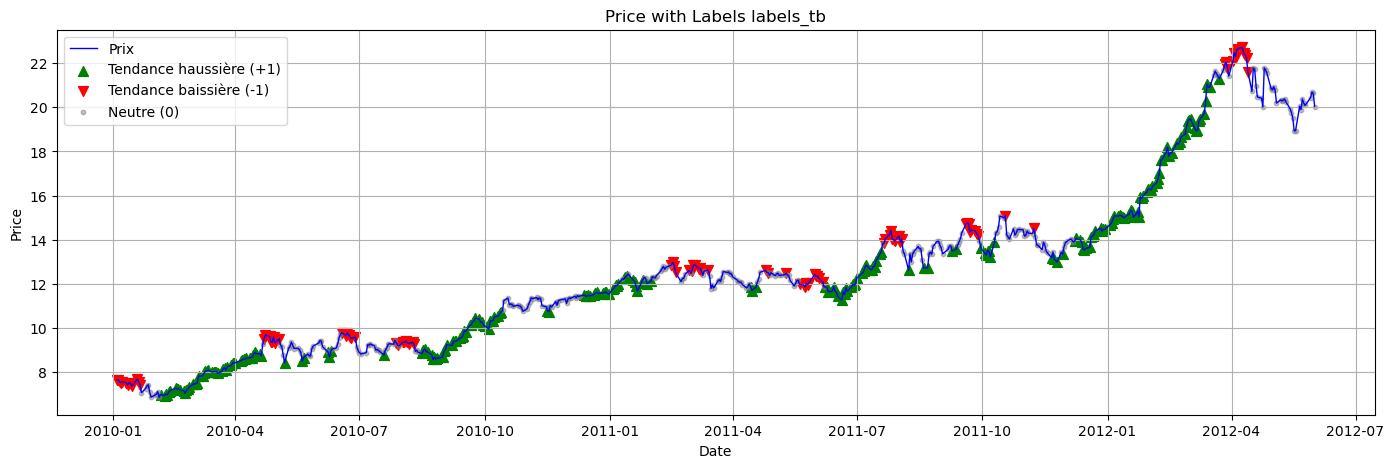

labels_tb
 0.0    265
 1.0    249
-1.0     95
Name: count, dtype: int64


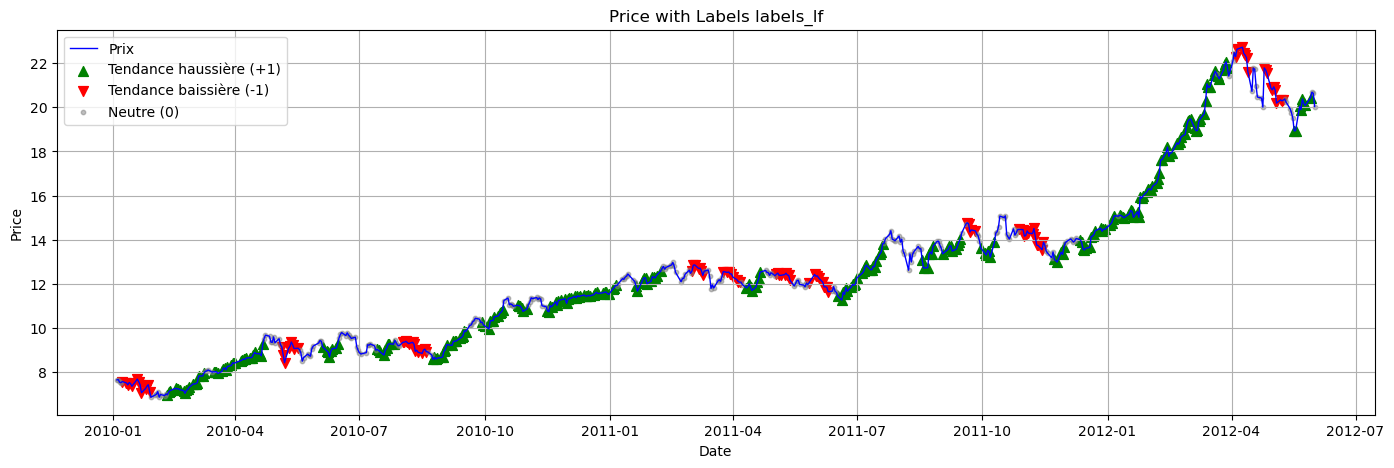

labels_lf
 1.0    287
 0.0    214
-1.0    108
Name: count, dtype: int64


In [5]:
# III. Plot some labels to see the differences
price_series = training_data['AAPL']['close'].loc['2010-01-01':'2012-06-01']
labels_tb = training_data['AAPL']['labels_tb'].loc['2010-01-01':'2012-06-01']
labels_lf = training_data['AAPL']['labels_lf'].loc['2010-01-01':'2012-06-01']

lib.plot_price_with_labels(price_series, labels_tb)
print(labels_tb.value_counts())

lib.plot_price_with_labels(price_series, labels_lf)
print(labels_lf.value_counts())

---
## **III. Feature Exploration**  

In this section, we will **generate and analyze features** to determine if they contain meaningful information for our model.  

### 🔍 **Objective**  
The goal is to create financial indicators that help distinguish different market conditions and improve model predictions.  

### ⚙️ **Feature Engineering Process**  
We will:  
1. **Generate features** – Extract technical, statistical, and market-based indicators.  
2. **Analyze their distributions** – Check for patterns and potential predictive power.  
3. **Assess feature importance** – Determine which features contribute the most to classification.  

In [6]:
# I. Create some features
params_general = {
    "window": [5, 10, 30, 60, 120],
    "smoothing_method": [None, "ewma"],
    "window_smooth": [10],
    "lambda_smooth": [0.2],
}

# Adapt the parameters for the specific features : Quantile & Hurst Exponent
params_quantile = params_general.copy()
params_quantile["quantile"] = [0.1, 0.9]

params_hurst = params_general.copy()
del params_hurst["window"]
params_hurst["power"] = [3, 4, 5]

# Extract features for each asset in the training data
label_features_training = {}
for ticker, asset_df in tqdm(training_data.items()):
    asset_df = asset_df.copy() 
    close_series = asset_df['close']
    
    average_features = lib.average_feature(data=close_series, params=params_general, n_jobs=9).extract()
    minimum_features = lib.minimum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    volatility_features = lib.volatility_feature(data=close_series, params=params_general, n_jobs=9).extract()
    quantile_features = lib.quantile_feature(data=close_series, params=params_quantile, n_jobs=9).extract()
    Z_momentum_features = lib.Z_momentum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    nonlinear_tempreg_features = lib.nonlinear_tempReg_feature(data=close_series, params=params_general, n_jobs=9).extract()
    hurst_exponent_features = lib.hurst_exponent_feature(data=close_series, params=params_hurst, n_jobs=9).extract()

    feature_df = pd.concat([average_features, minimum_features, volatility_features, quantile_features, Z_momentum_features, nonlinear_tempreg_features, hurst_exponent_features], axis=1)
    label_feature_df = pd.concat([feature_df, asset_df[['labels_tb', 'labels_lf']]], axis=1)
    label_features_training[ticker] = label_feature_df

# Also prepare the features for the testing data
label_features_testing = {}
for ticker, asset_df in tqdm(testing_data.items()):
    asset_df = asset_df.copy() 
    close_series = asset_df['close']
    
    average_features = lib.average_feature(data=close_series, params=params_general, n_jobs=9).extract()
    minimum_features = lib.minimum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    volatility_features = lib.volatility_feature(data=close_series, params=params_general, n_jobs=9).extract()
    quantile_features = lib.quantile_feature(data=close_series, params=params_quantile, n_jobs=9).extract()
    Z_momentum_features = lib.Z_momentum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    nonlinear_tempreg_features = lib.nonlinear_tempReg_feature(data=close_series, params=params_general, n_jobs=9).extract()
    hurst_exponent_features = lib.hurst_exponent_feature(data=close_series, params=params_hurst, n_jobs=9).extract()

    feature_df = pd.concat([average_features, minimum_features, volatility_features, quantile_features, Z_momentum_features, nonlinear_tempreg_features, hurst_exponent_features], axis=1)
    label_feature_df = pd.concat([feature_df, asset_df[['labels_tb', 'labels_lf']]], axis=1)
    label_features_testing[ticker] = label_feature_df

100%|██████████| 4/4 [00:49<00:00, 12.32s/it]


Correlation Matrix of Labels-Features on AAPl


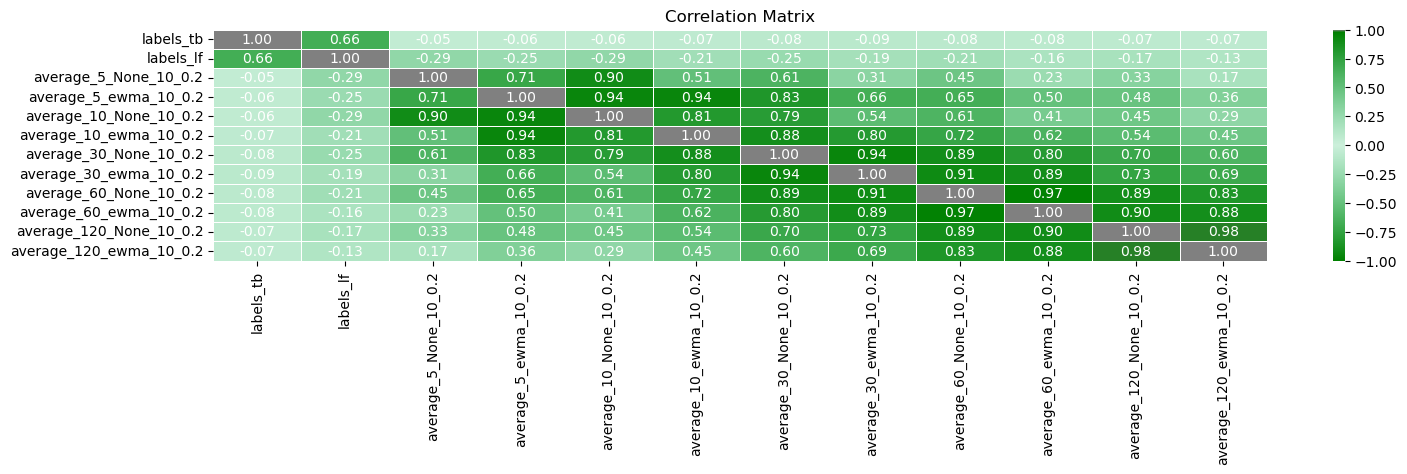

Correlation Matrix of Labels-Features on GME


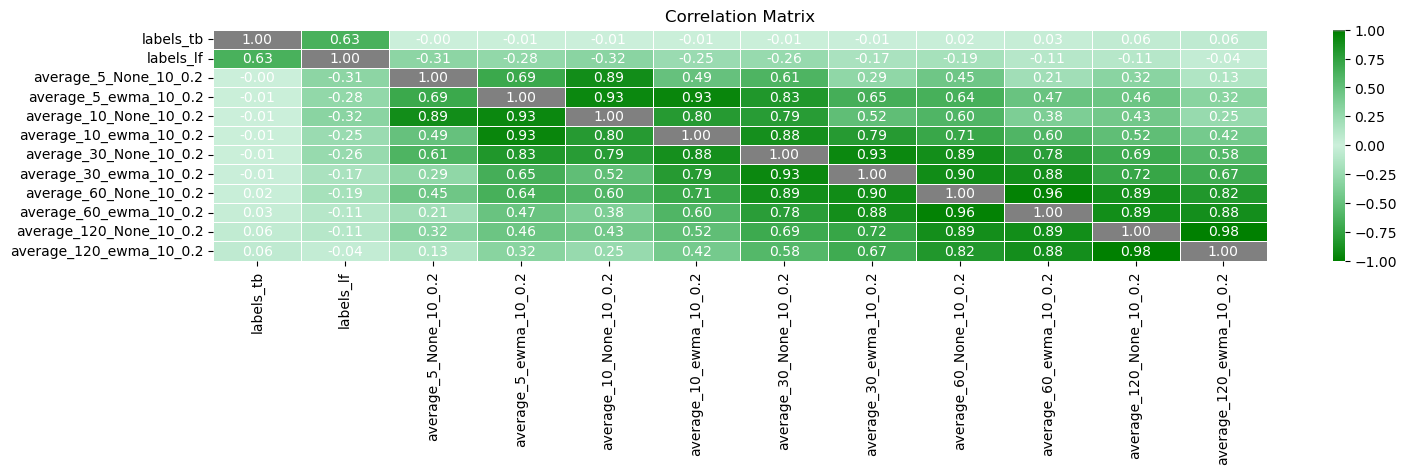

Correlation Matrix of Labels-Features on A


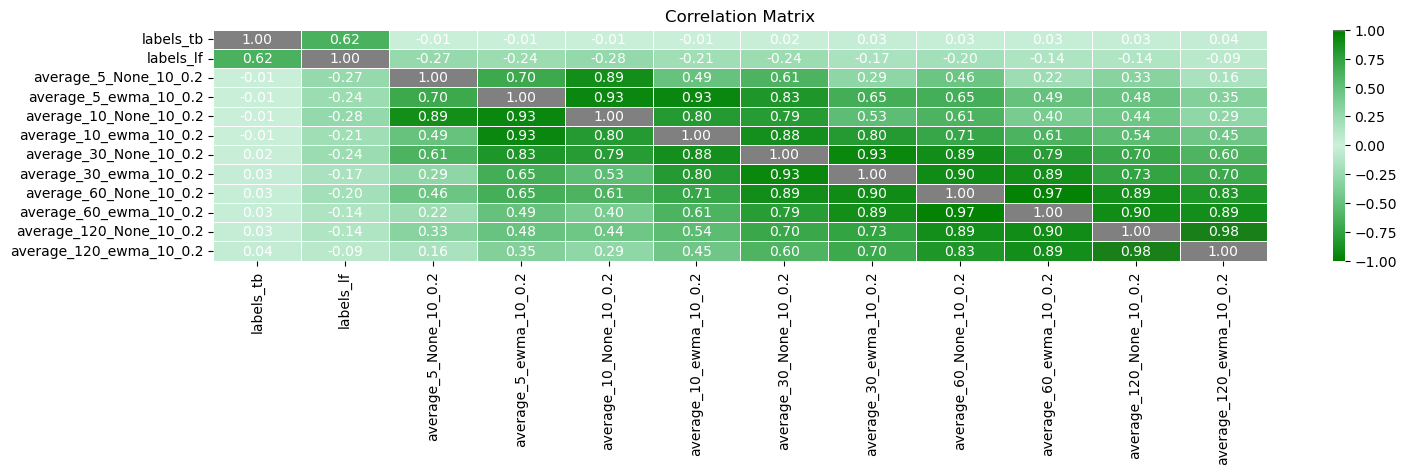

In [7]:
# Let's see the correlation matrix of the features with the labels
features_list = ['labels_tb', 'labels_lf'] + list(label_features_training['AAPL'].columns[:10])

print('Correlation Matrix of Labels-Features on AAPl')
lib.features_correlation(label_features_training['AAPL'][features_list])

print('Correlation Matrix of Labels-Features on GME')
lib.features_correlation(label_features_training['GME'][features_list])

print('Correlation Matrix of Labels-Features on A')
lib.features_correlation(label_features_training['A'][features_list])

Data Type: float64
Missing Values: 5, Unique Values: 3518
Zero Values: 0, Negative Values: 2000, Positive Values: 1518


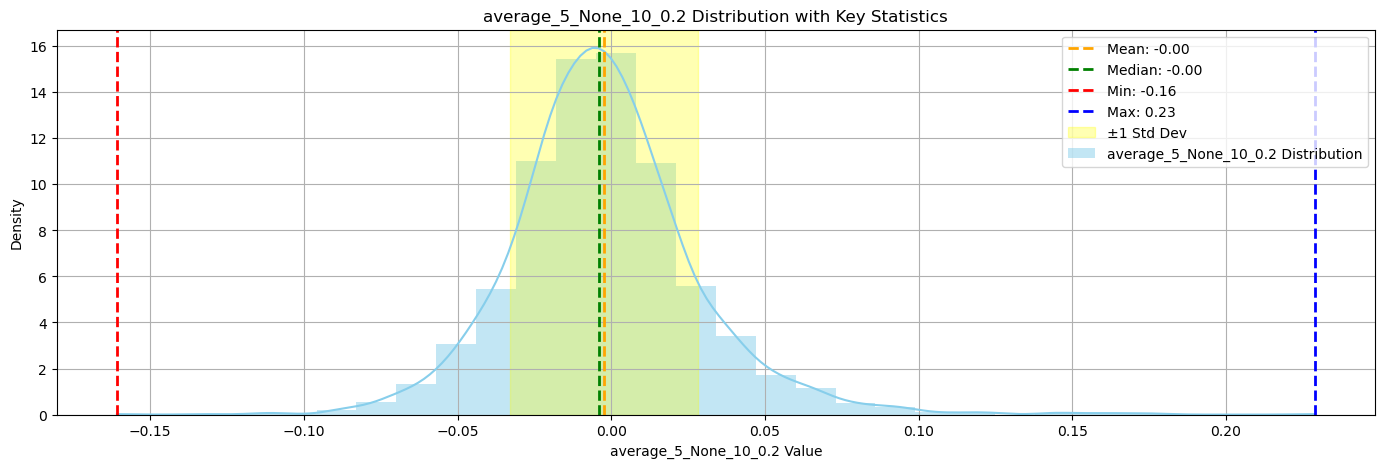

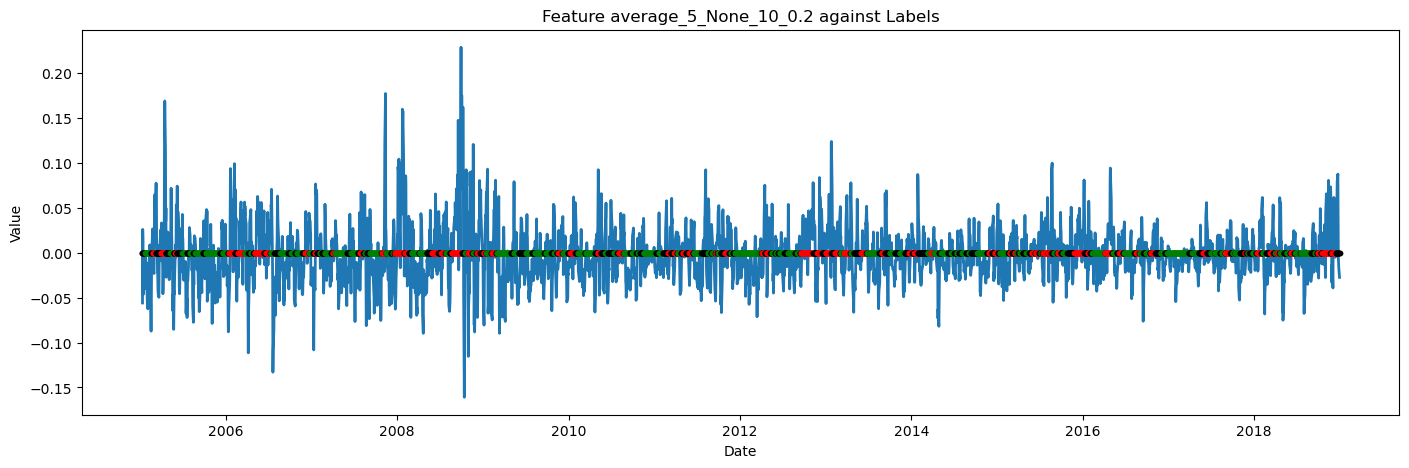

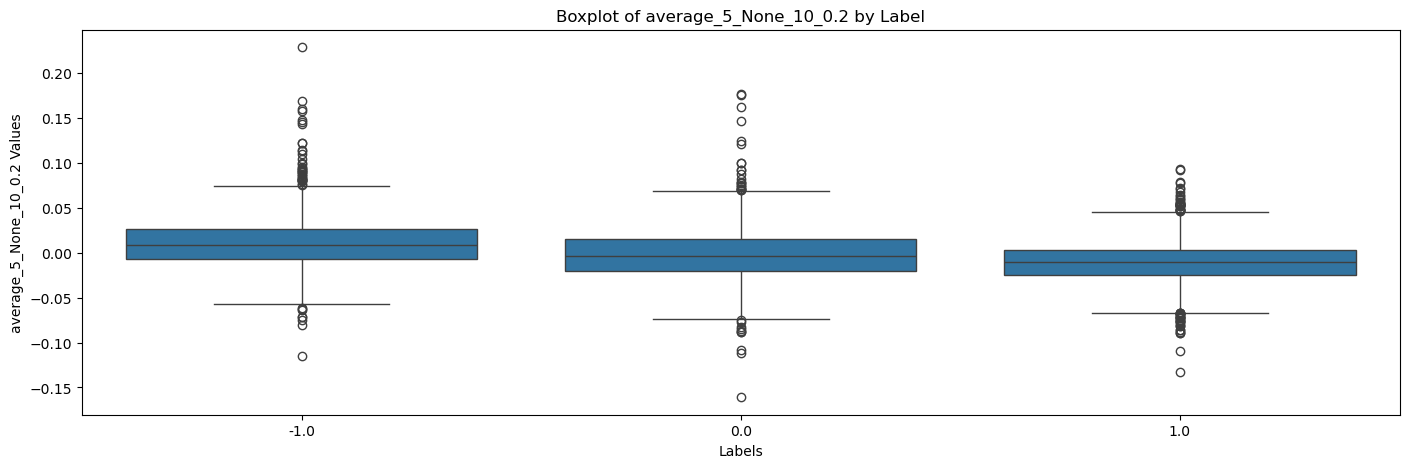

In [8]:
# Let's plot one feature to get some insights
average_5_feature = label_features_training['AAPL']['average_5_None_10_0.2']
labels_lf = label_features_training['AAPL']['labels_lf']

lib.feature_data(feature_series=average_5_feature)
lib.feature_distribution(feature_series=average_5_feature, feature_name='average_5_None_10_0.2')
lib.feature_plot(feature_series=average_5_feature, label_series=labels_lf, feature_name='average_5_None_10_0.2')

## **Feature Analysis Summary**

Our quick feature analysis reveals that the **Look Forward labelling method** yields significantly better correlations compared to the **Triple Barrier method**. This result is expected, as most of the selected features primarily capture **momentum effects**. Consequently, it makes sense that they provide a better explanation for a labelling approach designed to identify momentum periods.

### Key Observations
- Not all features exhibit the same level of explanatory power.
- Increasing the **window size** tends to reduce the effectiveness of features.
- This supports the hypothesis of **near-market efficiency**, where information is rapidly absorbed by the market, rendering older data less impactful.

These findings emphasize the importance of selecting an appropriate labelling method and optimizing window sizes to maximize feature relevance.

---
## **IV. Predictive Model**

In this section, we will train a Machine Learning model to evaluate the predictive power of our features and labels. The goal is to determine whether we can achieve strong predictive performance and gain valuable insights from the data.

### **Models**
We will explore various classification models, balancing interpretability and predictive performance. Potential models include:

- **Logistic Regression** – A simple yet effective baseline.
- **Random Forest** – A robust, interpretable ensemble method.
- **Gradient Boosting (e.g., XGBoost, LightGBM)** – Powerful tree-based models for capturing complex patterns.

In [9]:
"""
First, we will prepare the data for training the model using vertical stacking.
Using vertical stacking let the model see more patterns and generalize better.
"""
training_stacked_data = pd.concat([label_features_training[ticker] for ticker in training_data.keys()], axis=0, ignore_index=True)
training_stacked_data = training_stacked_data.drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2'])
training_stacked_data = training_stacked_data.dropna(axis=0)

X_train = training_stacked_data.drop(['labels_tb', 'labels_lf'], axis=1)
y_train_tb = training_stacked_data['labels_tb']
y_train_lf = training_stacked_data['labels_lf']

training_set = {
    'AAPL': label_features_training['AAPL'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'GME': label_features_training['GME'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'A': label_features_training['A'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'META': label_features_training['META'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
}

testing_set = {
    'AAPL': label_features_testing['AAPL'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'GME': label_features_testing['GME'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'A': label_features_testing['A'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'META': label_features_testing['META'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
}

## **First Model : Decision Tree**

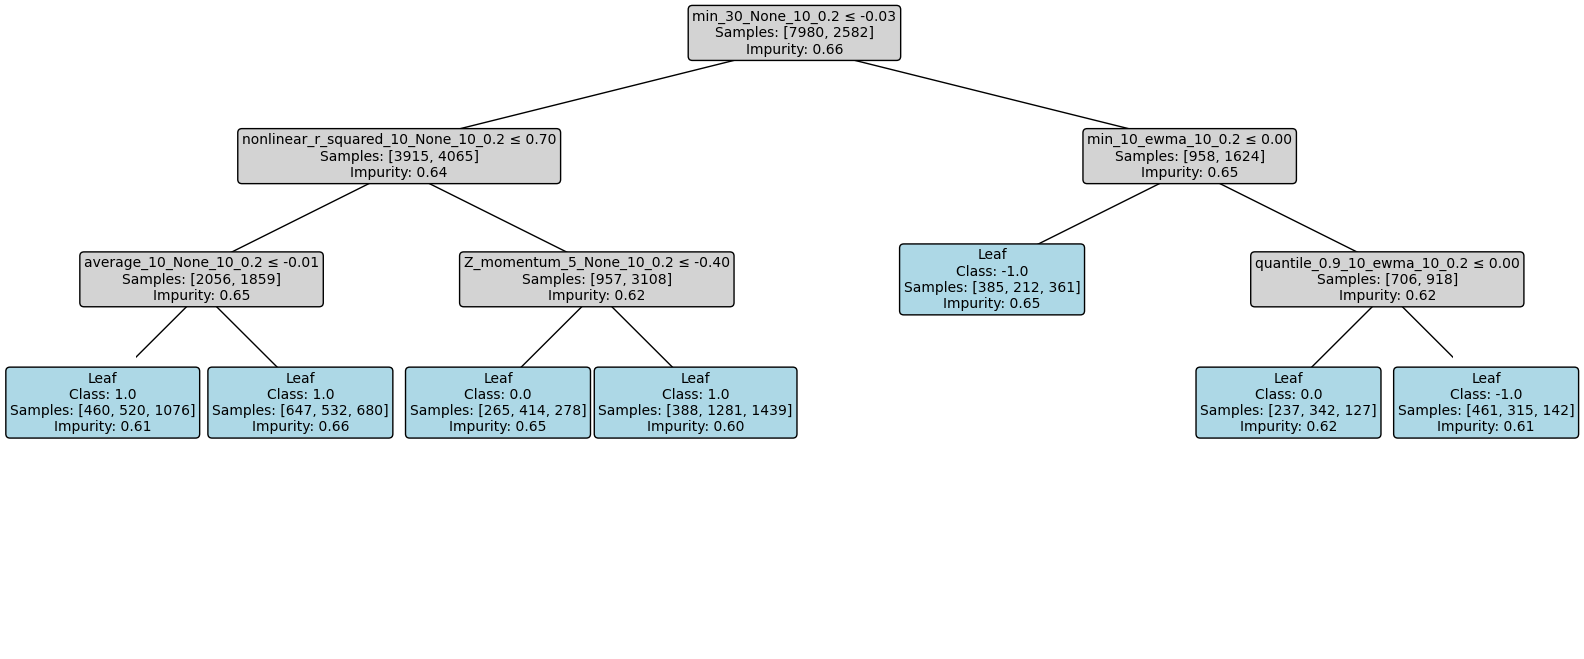

In [10]:
criterion = 'gini'
max_depth = 3
min_samples_split = 1000
min_samples_leaf = 500
max_features = 10
n_jobs = 9

decision_tree = lib.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=n_jobs)
decision_tree.fit(X_train, y_train_lf)
lib.plot_tree(decision_tree.root, feature_names=X_train.columns.tolist())

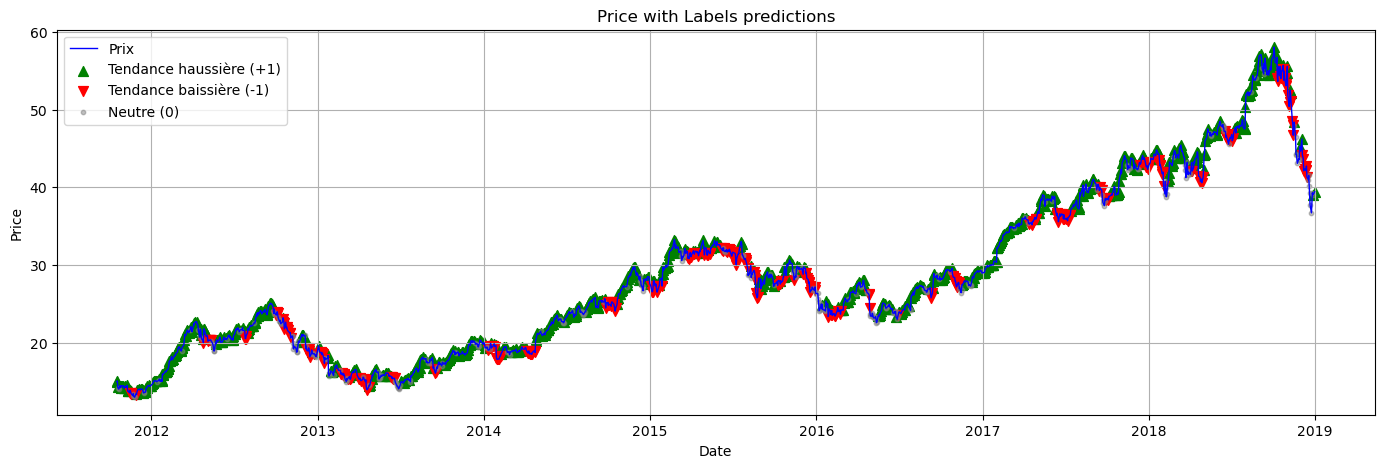

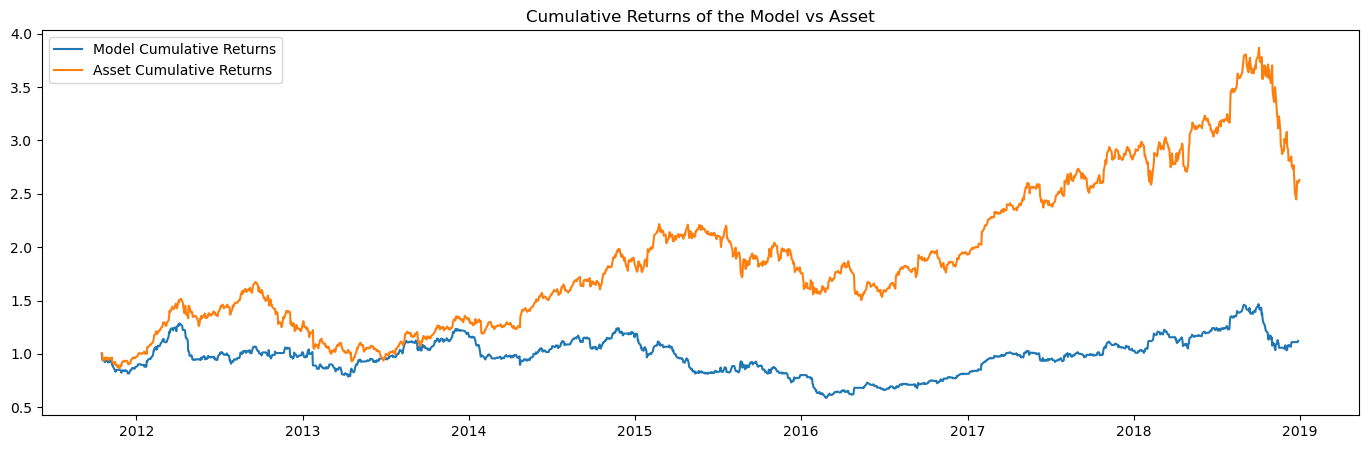

Sharpe Ratio: 0.18430324377374346, Calmar Ratio: 0.07665371283991591, Information Ratio: -0.373252821103174


In [11]:
predictions = decision_tree.predict(training_set['AAPL'].drop(['labels_tb', 'labels_lf'], axis=1))
training_set['AAPL']['predictions'] = predictions
training_data['AAPL'].loc[:, 'predictions'] = training_set['AAPL']['predictions']

plotting_data = training_data['AAPL'].copy().dropna(axis=0)
plotting_data['asset_returns'] = plotting_data['close'].pct_change()
plotting_data['model_returns'] = plotting_data['predictions'] * plotting_data['asset_returns'].shift(-1)
plotting_data['model_cumret'] = (1 + plotting_data['model_returns']).cumprod()
plotting_data['asset_cumret'] = (1 + plotting_data['asset_returns']).cumprod()

lib.plot_price_with_labels(plotting_data['close'], plotting_data['predictions'])
plt.figure(figsize=(17, 5))
plt.plot(plotting_data['model_cumret'], label='Model Cumulative Returns')
plt.plot(plotting_data['asset_cumret'], label='Asset Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns of the Model vs Asset')
plt.show()

performance_stats, _ = lib.get_performance_measures(returns_series=plotting_data['model_returns'], market_returns=plotting_data['asset_returns'])
print(f'Sharpe Ratio: {performance_stats["sharpe_ratio"]}, Calmar Ratio: {performance_stats["calmar_ratio"]}, Information Ratio: {performance_stats["information_ratio"]}')

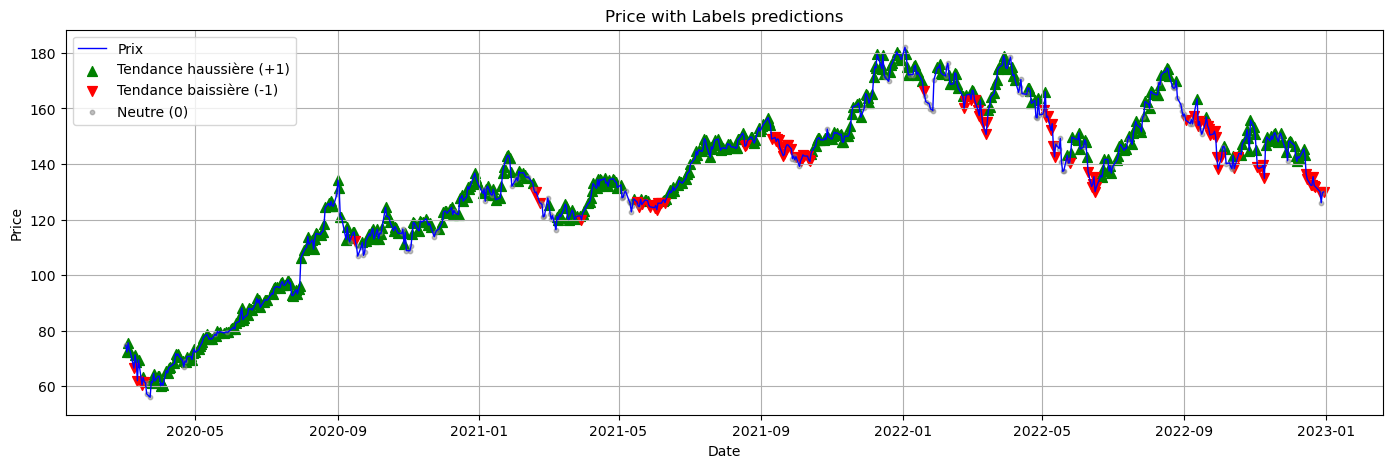

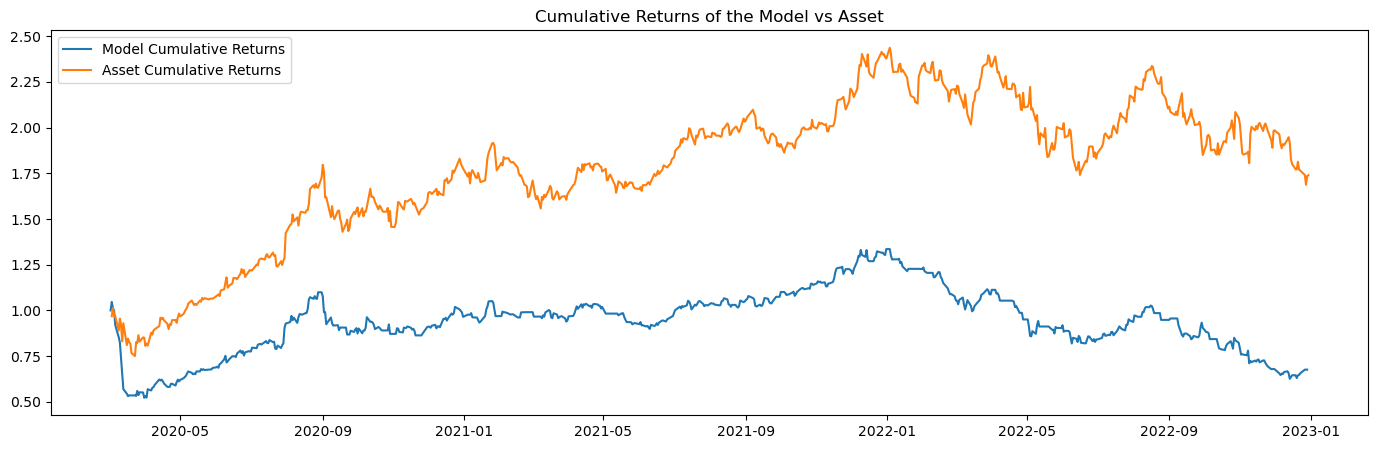

Sharpe Ratio: -0.24505473098584502, Calmar Ratio: -0.1537870108022766, Information Ratio: -0.6859952087056751


In [12]:
predictions = decision_tree.predict(testing_set['AAPL'].drop(['labels_tb', 'labels_lf'], axis=1))
testing_set['AAPL']['predictions'] = predictions
testing_data['AAPL'].loc[:, 'predictions'] = testing_set['AAPL']['predictions']

plotting_data = testing_data['AAPL'].copy().dropna(axis=0)
plotting_data['asset_returns'] = plotting_data['close'].pct_change()
plotting_data['model_returns'] = plotting_data['predictions'] * plotting_data['asset_returns'].shift(-1)
plotting_data['model_cumret'] = (1 + plotting_data['model_returns']).cumprod()
plotting_data['asset_cumret'] = (1 + plotting_data['asset_returns']).cumprod()

lib.plot_price_with_labels(plotting_data['close'], plotting_data['predictions'])
plt.figure(figsize=(17, 5))
plt.plot(plotting_data['model_cumret'], label='Model Cumulative Returns')
plt.plot(plotting_data['asset_cumret'], label='Asset Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns of the Model vs Asset')
plt.show()

performance_stats, _ = lib.get_performance_measures(returns_series=plotting_data['model_returns'], market_returns=plotting_data['asset_returns'])
print(f'Sharpe Ratio: {performance_stats["sharpe_ratio"]}, Calmar Ratio: {performance_stats["calmar_ratio"]}, Information Ratio: {performance_stats["information_ratio"]}')